In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/BanglaCharacterDataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Train/201/bcc000060.bmp  
  inflating: Dataset/Train/201/bcc000061.bmp  
  inflating: Dataset/Train/201/bcc000062.bmp  
  inflating: Dataset/Train/201/bcc000063.bmp  
  inflating: Dataset/Train/201/bcc000064.bmp  
  inflating: Dataset/Train/201/bcc000065.bmp  
  inflating: Dataset/Train/201/bcc000066.bmp  
  inflating: Dataset/Train/201/bcc000067.bmp  
  inflating: Dataset/Train/201/bcc000068.bmp  
  inflating: Dataset/Train/201/bcc000069.bmp  
  inflating: Dataset/Train/201/bcc000070.bmp  
  inflating: Dataset/Train/201/bcc000071.bmp  
  inflating: Dataset/Train/201/bcc000072.bmp  
  inflating: Dataset/Train/201/bcc000073.bmp  
  inflating: Dataset/Train/201/bcc000074.bmp  
  inflating: Dataset/Train/201/bcc000075.bmp  
  inflating: Dataset/Train/201/bcc000076.bmp  
  inflating: Dataset/Train/201/bcc000077.bmp  
  inflating: Dataset/Train/201/bcc000078.bmp  
  inflating: Dataset/Train/201/bcc000079.bmp  
  inflati

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import functional as Flatten
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchsummary import summary

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import random

import warnings as wrn
wrn.filterwarnings('ignore')

In [ ]:
ROOT_DIR = '/content/Dataset'
TRAIN_ROOT = os.path.join(ROOT_DIR, 'Train')
TEST_ROOT = os.path.join(ROOT_DIR, 'Test')
CHECKPOINT = ''

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

IMG_SIZE = (64, 64)
BATCH_SIZE = 32

N_CLASSES = len(os.listdir(TRAIN_ROOT))

In [ ]:
paths = glob.glob('/content/Dataset/*/*/*.bmp')

df = pd.DataFrame({'Path': paths})

def extract_label(path):
    return path.split('/')[-2]

def extract_set(path):
    return path.split('/')[-3]

df['Label'] = df['Path'].apply(extract_label)
df = pd.concat([df, pd.get_dummies(df['Label'])], axis = 1)

df['Set'] = df['Path'].apply(extract_set)

train_df = df.loc[df['Set'] == 'Train'].iloc[:, :-1]
test_df = df.loc[df['Set'] == 'Test'].iloc[:, :-1]

In [ ]:
df

,Path,Label,172,173,174,175,176,177,178,179,...,213,214,215,216,217,218,219,220,221,Set
0,/content/Dataset/Train/200/bcc000183.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
1,/content/Dataset/Train/200/bcc000108.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
2,/content/Dataset/Train/200/bcc000145.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
3,/content/Dataset/Train/200/bcc000171.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
4,/content/Dataset/Train/200/bcc000082.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,/content/Dataset/Test/181/bcc000020.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test
14996,/content/Dataset/Test/181/bcc000015.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test
14997,/content/Dataset/Test/181/bcc000055.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test
14998,/content/Dataset/Test/181/bcc000016.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test


In [ ]:
train_df

,Path,Label,172,173,174,175,176,177,178,179,...,212,213,214,215,216,217,218,219,220,221
0,/content/Dataset/Train/200/bcc000183.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,/content/Dataset/Train/200/bcc000108.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/content/Dataset/Train/200/bcc000145.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,/content/Dataset/Train/200/bcc000171.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,/content/Dataset/Train/200/bcc000082.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,/content/Dataset/Train/181/bcc000181.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11996,/content/Dataset/Train/181/bcc000086.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11997,/content/Dataset/Train/181/bcc000067.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,/content/Dataset/Train/181/bcc000066.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df

,Path,Label,172,173,174,175,176,177,178,179,...,212,213,214,215,216,217,218,219,220,221
12000,/content/Dataset/Test/200/bcc000034.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12001,/content/Dataset/Test/200/bcc000057.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12002,/content/Dataset/Test/200/bcc000000.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12003,/content/Dataset/Test/200/bcc000006.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12004,/content/Dataset/Test/200/bcc000044.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,/content/Dataset/Test/181/bcc000020.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14996,/content/Dataset/Test/181/bcc000015.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,/content/Dataset/Test/181/bcc000055.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14998,/content/Dataset/Test/181/bcc000016.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(40, 117, 3)


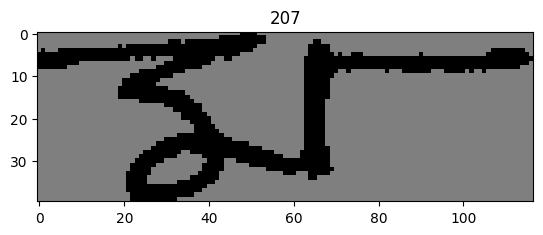

In [ ]:
import matplotlib.pyplot as plt
import random

def imshow():
    idx = random.randint(0, len(train_df))
    img = plt.imread(train_df['Path'][idx])
    label = train_df['Label'][idx]
    print(img.shape)
    plt.imshow(img)
    plt.title(label)
    plt.show()

imshow()

In [ ]:
class CustomDatasetLoader(torch.utils.data.Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 0]
        img = cv2.imread(path)

        if self.transform:
            img = self.transform(img)

        label = torch.from_numpy(self.df.iloc[idx, 2:].values.astype(float))

        return (img, label)

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(IMG_SIZE),
    # torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
])

train_data = CustomDatasetLoader(df = train_df, transform = transform)
test_data = CustomDatasetLoader(df = test_df, transform = transform)
all_data = CustomDatasetLoader(df = df.iloc[:, :-1], transform = transform)

train_loader = torch.utils.data.DataLoader(
    dataset = train_data, batch_size = 32, shuffle = True, num_workers = 1, drop_last = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
)
all_data_loader = torch.utils.data.DataLoader(
    dataset = all_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
)

In [ ]:
for (images, labels) in all_data_loader:
    print(images.shape)
    print(labels.shape)
    break

all_data.__len__()

torch.Size([64, 3, 64, 64])
torch.Size([64, 50])


15000

In [ ]:
# conv out = ((i+2p-k)/s)+1
# convtrans out = (i-1)*s+k-2p

In [ ]:
class ResizeConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

In [ ]:
class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [ ]:
class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [ ]:
class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * z_dim)

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

In [ ]:
class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 3, 64, 64)
        return x

In [ ]:
# z, mu, logvar, recon_imgs

In [ ]:
class VAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return z, mean, logvar, x

    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [ ]:
model = VAE(z_dim = 64).to(DEVICE)

In [ ]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,728
       BatchNorm2d-2           [-1, 64, 16, 16]             128
            Conv2d-3           [-1, 64, 16, 16]          36,864
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
     BasicBlockEnc-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
           Conv2d-10           [-1, 64, 16, 16]          36,864
      BatchNorm2d-11           [-1, 64, 16, 16]             128
    BasicBlockEnc-12           [-1, 64, 16, 16]               0
           Conv2d-13            [-1, 128, 8, 8]          73,728
      BatchNorm2d-14            [-1, 12

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def criterion(recon_img, img, mu, logvar):
    # recon_loss = F.mse_loss(recon_img, img)
    recon_loss = F.binary_cross_entropy(recon_img, img, size_average=False)
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp(), dim=1), dim=0)
    return recon_loss+KLD, recon_loss, KLD

In [ ]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for idx, batch in enumerate(tqdm(iterator)):
        images, _ = batch
        images = images.to(DEVICE)
        optimizer.zero_grad()
        z, mu, logvar, recon_imgs = model(images)
        loss, recon_loss, kld_loss = criterion(recon_imgs, images, mu, logvar)
        loss.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1)
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [ ]:
best_loss = 1e10
for epoch in range(201):
    if os.path.exists('model.pth'):
        model.load_state_dict(torch.load('model.pth'))
    print(f"Epoch - {epoch}")
    loss = train(model, train_loader, optimizer, criterion)
    print(f"Loss - {loss:.2f}\n")

    if epoch % 10 == 0 and loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch - 0


100%|██████████| 375/375 [00:31<00:00, 11.92it/s]


Loss - 3193388715.47

--------------------
Model Saved
--------------------
Epoch - 1


100%|██████████| 375/375 [00:31<00:00, 12.08it/s]


Loss - 257200.35

Epoch - 2


100%|██████████| 375/375 [00:31<00:00, 12.09it/s]


Loss - 257477.59

Epoch - 3


100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


Loss - 257307.20

Epoch - 4


100%|██████████| 375/375 [00:30<00:00, 12.16it/s]


Loss - 257221.28

Epoch - 5


100%|██████████| 375/375 [00:31<00:00, 12.03it/s]


Loss - 1481774.60

Epoch - 6


100%|██████████| 375/375 [00:31<00:00, 12.08it/s]


Loss - 257405.44

Epoch - 7


100%|██████████| 375/375 [00:31<00:00, 11.95it/s]


Loss - 257189.39

Epoch - 8


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Loss - 258300.80

Epoch - 9


100%|██████████| 375/375 [00:30<00:00, 12.20it/s]


Loss - 257446.01

Epoch - 10


100%|██████████| 375/375 [00:30<00:00, 12.22it/s]


Loss - 257568.25

--------------------
Model Saved
--------------------
Epoch - 11


100%|██████████| 375/375 [00:30<00:00, 12.16it/s]


Loss - 255807.94

Epoch - 12


100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


Loss - 256520.78

Epoch - 13


100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


Loss - 256661.69

Epoch - 14


100%|██████████| 375/375 [00:30<00:00, 12.12it/s]


Loss - 257761.17

Epoch - 15


100%|██████████| 375/375 [00:31<00:00, 12.04it/s]


Loss - 256068.58

Epoch - 16


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 257108.54

Epoch - 17


100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


Loss - 256294.93

Epoch - 18


100%|██████████| 375/375 [00:30<00:00, 12.23it/s]


Loss - 256279.91

Epoch - 19


100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


Loss - 256367.49

Epoch - 20


100%|██████████| 375/375 [00:30<00:00, 12.16it/s]


Loss - 256518.77

--------------------
Model Saved
--------------------
Epoch - 21


100%|██████████| 375/375 [00:30<00:00, 12.19it/s]


Loss - 255416.82

Epoch - 22


100%|██████████| 375/375 [00:30<00:00, 12.24it/s]


Loss - 256847.55

Epoch - 23


100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


Loss - 254908.49

Epoch - 24


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Loss - 255224.09

Epoch - 25


100%|██████████| 375/375 [00:30<00:00, 12.20it/s]


Loss - 255545.10

Epoch - 26


100%|██████████| 375/375 [00:31<00:00, 12.06it/s]


Loss - 255359.44

Epoch - 27


100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


Loss - 254893.45

Epoch - 28


100%|██████████| 375/375 [00:30<00:00, 12.17it/s]


Loss - 255431.33

Epoch - 29


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Loss - 255741.87

Epoch - 30


100%|██████████| 375/375 [00:30<00:00, 12.22it/s]


Loss - 254886.66

--------------------
Model Saved
--------------------
Epoch - 31


100%|██████████| 375/375 [00:30<00:00, 12.27it/s]


Loss - 254120.65

Epoch - 32


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 254169.78

Epoch - 33


100%|██████████| 375/375 [00:31<00:00, 11.99it/s]


Loss - 254350.59

Epoch - 34


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 253980.46

Epoch - 35


100%|██████████| 375/375 [00:31<00:00, 12.05it/s]


Loss - 254460.41

Epoch - 36


100%|██████████| 375/375 [00:30<00:00, 12.22it/s]


Loss - 254388.80

Epoch - 37


100%|██████████| 375/375 [00:30<00:00, 12.20it/s]


Loss - 253631.80

Epoch - 38


100%|██████████| 375/375 [00:31<00:00, 12.09it/s]


Loss - 253635.94

Epoch - 39


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 255280.34

Epoch - 40


100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


Loss - 253824.84

--------------------
Model Saved
--------------------
Epoch - 41


100%|██████████| 375/375 [00:30<00:00, 12.19it/s]


Loss - 252971.40

Epoch - 42


100%|██████████| 375/375 [00:30<00:00, 12.15it/s]


Loss - 253001.31

Epoch - 43


100%|██████████| 375/375 [00:30<00:00, 12.17it/s]


Loss - 252539.94

Epoch - 44


100%|██████████| 375/375 [00:30<00:00, 12.25it/s]


Loss - 252831.03

Epoch - 45


100%|██████████| 375/375 [00:31<00:00, 12.06it/s]


Loss - 252774.62

Epoch - 46


100%|██████████| 375/375 [00:30<00:00, 12.25it/s]


Loss - 253005.49

Epoch - 47


100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


Loss - 252531.69

Epoch - 48


100%|██████████| 375/375 [00:30<00:00, 12.20it/s]


Loss - 252551.41

Epoch - 49


100%|██████████| 375/375 [00:30<00:00, 12.26it/s]


Loss - 252750.60

Epoch - 50


100%|██████████| 375/375 [00:30<00:00, 12.28it/s]


Loss - 252604.99

--------------------
Model Saved
--------------------
Epoch - 51


100%|██████████| 375/375 [00:30<00:00, 12.11it/s]


Loss - 251186.36

Epoch - 52


100%|██████████| 375/375 [00:30<00:00, 12.22it/s]


Loss - 251154.30

Epoch - 53


100%|██████████| 375/375 [00:30<00:00, 12.29it/s]


Loss - 251030.97

Epoch - 54


100%|██████████| 375/375 [00:30<00:00, 12.12it/s]


Loss - 251937.77

Epoch - 55


100%|██████████| 375/375 [00:30<00:00, 12.25it/s]


Loss - 251461.33

Epoch - 56


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Loss - 252405.80

Epoch - 57


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Loss - 251029.77

Epoch - 58


100%|██████████| 375/375 [00:30<00:00, 12.15it/s]


Loss - 251001.07

Epoch - 59


100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


Loss - 251526.49

Epoch - 60


100%|██████████| 375/375 [00:30<00:00, 12.15it/s]


Loss - 250989.39

--------------------
Model Saved
--------------------
Epoch - 61


100%|██████████| 375/375 [00:30<00:00, 12.12it/s]


Loss - 252718.06

Epoch - 62


100%|██████████| 375/375 [00:30<00:00, 12.26it/s]


Loss - 249435.61

Epoch - 63


100%|██████████| 375/375 [00:30<00:00, 12.22it/s]


Loss - 250353.22

Epoch - 64


100%|██████████| 375/375 [00:31<00:00, 12.08it/s]


Loss - 249483.53

Epoch - 65


100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


Loss - 249473.03

Epoch - 66


100%|██████████| 375/375 [00:30<00:00, 12.10it/s]


Loss - 249199.39

Epoch - 67


100%|██████████| 375/375 [00:30<00:00, 12.22it/s]


Loss - 249757.30

Epoch - 68


100%|██████████| 375/375 [00:30<00:00, 12.23it/s]


Loss - 249679.91

Epoch - 69


100%|██████████| 375/375 [00:30<00:00, 12.23it/s]


Loss - 250298.53

Epoch - 70


100%|██████████| 375/375 [00:31<00:00, 12.04it/s]


Loss - 250949.84

--------------------
Model Saved
--------------------
Epoch - 71


100%|██████████| 375/375 [00:30<00:00, 12.26it/s]


Loss - 248051.50

Epoch - 72


100%|██████████| 375/375 [00:30<00:00, 12.11it/s]


Loss - 248298.35

Epoch - 73


100%|██████████| 375/375 [00:31<00:00, 12.00it/s]


Loss - 247815.70

Epoch - 74


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Loss - 248626.90

Epoch - 75


100%|██████████| 375/375 [00:30<00:00, 12.20it/s]


Loss - 248204.79

Epoch - 76


100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


Loss - 247933.95

Epoch - 77


100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


Loss - 248432.69

Epoch - 78


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 248222.19

Epoch - 79


100%|██████████| 375/375 [00:30<00:00, 12.17it/s]


Loss - 248269.34

Epoch - 80


100%|██████████| 375/375 [00:30<00:00, 12.16it/s]


Loss - 248264.18

--------------------
Model Saved
--------------------
Epoch - 81


100%|██████████| 375/375 [00:30<00:00, 12.27it/s]


Loss - 245253.78

Epoch - 82


100%|██████████| 375/375 [00:30<00:00, 12.26it/s]


Loss - 245390.10

Epoch - 83


100%|██████████| 375/375 [00:31<00:00, 11.92it/s]


Loss - 245674.33

Epoch - 84


100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


Loss - 246023.51

Epoch - 85


100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


Loss - 245739.45

Epoch - 86


100%|██████████| 375/375 [00:30<00:00, 12.26it/s]


Loss - 245310.19

Epoch - 87


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 248636.65

Epoch - 88


100%|██████████| 375/375 [00:30<00:00, 12.17it/s]


Loss - 245715.81

Epoch - 89


100%|██████████| 375/375 [00:30<00:00, 12.20it/s]


Loss - 246494.38

Epoch - 90


100%|██████████| 375/375 [00:30<00:00, 12.23it/s]


Loss - 245522.38

--------------------
Model Saved
--------------------
Epoch - 91


100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


Loss - 245283.30

Epoch - 92


100%|██████████| 375/375 [00:31<00:00, 12.00it/s]


Loss - 243173.27

Epoch - 93


100%|██████████| 375/375 [00:30<00:00, 12.17it/s]


Loss - 244148.34

Epoch - 94


100%|██████████| 375/375 [00:30<00:00, 12.24it/s]


Loss - 242753.01

Epoch - 95


100%|██████████| 375/375 [00:30<00:00, 12.17it/s]


Loss - 244751.86

Epoch - 96


100%|██████████| 375/375 [00:31<00:00, 12.07it/s]


Loss - 243159.09

Epoch - 97


100%|██████████| 375/375 [00:30<00:00, 12.27it/s]


Loss - 243171.80

Epoch - 98


100%|██████████| 375/375 [00:30<00:00, 12.26it/s]


Loss - 242977.45

Epoch - 99


100%|██████████| 375/375 [00:30<00:00, 12.19it/s]


Loss - 244214.16

Epoch - 100


100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


Loss - 243322.24

--------------------
Model Saved
--------------------
Epoch - 101


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Loss - 241386.99

Epoch - 102


100%|██████████| 375/375 [00:31<00:00, 12.07it/s]


Loss - 241622.72

Epoch - 103


100%|██████████| 375/375 [00:30<00:00, 12.22it/s]


Loss - 241697.56

Epoch - 104


100%|██████████| 375/375 [00:30<00:00, 12.24it/s]


Loss - 241673.86

Epoch - 105


100%|██████████| 375/375 [00:31<00:00, 12.09it/s]


Loss - 241160.96

Epoch - 106


100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


Loss - 241385.76

Epoch - 107


100%|██████████| 375/375 [00:30<00:00, 12.15it/s]


Loss - 241670.25

Epoch - 108


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Loss - 241268.52

Epoch - 109


100%|██████████| 375/375 [00:31<00:00, 12.09it/s]


Loss - 241752.18

Epoch - 110


100%|██████████| 375/375 [00:30<00:00, 12.12it/s]


Loss - 241916.47

--------------------
Model Saved
--------------------
Epoch - 111


100%|██████████| 375/375 [00:31<00:00, 12.08it/s]


Loss - 239504.08

Epoch - 112


100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


Loss - 240166.95

Epoch - 113


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Loss - 240155.36

Epoch - 114


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 239870.81

Epoch - 115


100%|██████████| 375/375 [00:30<00:00, 12.23it/s]


Loss - 239688.70

Epoch - 116


100%|██████████| 375/375 [00:30<00:00, 12.19it/s]


Loss - 239610.66

Epoch - 117


100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


Loss - 239744.90

Epoch - 118


100%|██████████| 375/375 [00:31<00:00, 12.00it/s]


Loss - 239711.81

Epoch - 119


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Loss - 240387.80

Epoch - 120


100%|██████████| 375/375 [00:31<00:00, 12.08it/s]


Loss - 240171.96

--------------------
Model Saved
--------------------
Epoch - 121


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 237978.02

Epoch - 122


100%|██████████| 375/375 [00:31<00:00, 12.06it/s]


Loss - 238877.56

Epoch - 123


100%|██████████| 375/375 [00:31<00:00, 12.09it/s]


Loss - 238099.66

Epoch - 124


100%|██████████| 375/375 [00:30<00:00, 12.15it/s]


Loss - 238143.94

Epoch - 125


100%|██████████| 375/375 [00:30<00:00, 12.15it/s]


Loss - 238009.42

Epoch - 126


100%|██████████| 375/375 [00:31<00:00, 11.98it/s]


Loss - 238422.57

Epoch - 127


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 238444.33

Epoch - 128


100%|██████████| 375/375 [00:30<00:00, 12.15it/s]


Loss - 238120.61

Epoch - 129


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Loss - 239387.24

Epoch - 130


100%|██████████| 375/375 [00:31<00:00, 11.89it/s]


Loss - 238390.23

--------------------
Model Saved
--------------------
Epoch - 131


100%|██████████| 375/375 [00:30<00:00, 12.19it/s]


Loss - 236387.53

Epoch - 132


100%|██████████| 375/375 [00:31<00:00, 12.10it/s]


Loss - 237104.89

Epoch - 133


100%|██████████| 375/375 [00:30<00:00, 12.11it/s]


Loss - 238340.68

Epoch - 134


100%|██████████| 375/375 [00:31<00:00, 12.08it/s]


Loss - 236302.69

Epoch - 135


100%|██████████| 375/375 [00:31<00:00, 12.01it/s]


Loss - 236306.57

Epoch - 136


100%|██████████| 375/375 [00:30<00:00, 12.12it/s]


Loss - 236187.15

Epoch - 137


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 236284.92

Epoch - 138


100%|██████████| 375/375 [00:31<00:00, 12.04it/s]


Loss - 236588.91

Epoch - 139


100%|██████████| 375/375 [00:31<00:00, 11.89it/s]


Loss - 236452.76

Epoch - 140


100%|██████████| 375/375 [00:30<00:00, 12.12it/s]


Loss - 236422.20

--------------------
Model Saved
--------------------
Epoch - 141


100%|██████████| 375/375 [00:30<00:00, 12.16it/s]


Loss - 235768.92

Epoch - 142


100%|██████████| 375/375 [00:30<00:00, 12.16it/s]


Loss - 235350.16

Epoch - 143


100%|██████████| 375/375 [00:31<00:00, 12.04it/s]


Loss - 235292.94

Epoch - 144


100%|██████████| 375/375 [00:31<00:00, 12.04it/s]


Loss - 235213.84

Epoch - 145


100%|██████████| 375/375 [00:30<00:00, 12.11it/s]


Loss - 235371.86

Epoch - 146


100%|██████████| 375/375 [00:30<00:00, 12.12it/s]


Loss - 235269.01

Epoch - 147


100%|██████████| 375/375 [00:31<00:00, 12.02it/s]


Loss - 235557.62

Epoch - 148


100%|██████████| 375/375 [00:31<00:00, 11.97it/s]


Loss - 235631.70

Epoch - 149


100%|██████████| 375/375 [00:31<00:00, 11.92it/s]


Loss - 235260.60

Epoch - 150


100%|██████████| 375/375 [00:31<00:00, 12.07it/s]


Loss - 235307.97

--------------------
Model Saved
--------------------
Epoch - 151


100%|██████████| 375/375 [00:31<00:00, 12.08it/s]


Loss - 233476.29

Epoch - 152


100%|██████████| 375/375 [00:31<00:00, 11.92it/s]


Loss - 233552.27

Epoch - 153


100%|██████████| 375/375 [00:30<00:00, 12.10it/s]


Loss - 233544.78

Epoch - 154


100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


Loss - 234378.99

Epoch - 155


100%|██████████| 375/375 [00:31<00:00, 12.07it/s]


Loss - 233335.36

Epoch - 156


100%|██████████| 375/375 [00:30<00:00, 12.10it/s]


Loss - 233486.05

Epoch - 157


100%|██████████| 375/375 [00:30<00:00, 12.15it/s]


Loss - 233407.98

Epoch - 158


100%|██████████| 375/375 [00:31<00:00, 12.00it/s]


Loss - 233277.79

Epoch - 159


100%|██████████| 375/375 [00:31<00:00, 12.05it/s]


Loss - 233496.00

Epoch - 160


100%|██████████| 375/375 [00:31<00:00, 12.01it/s]


Loss - 233368.68

--------------------
Model Saved
--------------------
Epoch - 161


100%|██████████| 375/375 [00:30<00:00, 12.17it/s]


Loss - 232185.52

Epoch - 162


100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


Loss - 232245.07

Epoch - 163


100%|██████████| 375/375 [00:30<00:00, 12.15it/s]


Loss - 232221.58

Epoch - 164


100%|██████████| 375/375 [00:30<00:00, 12.11it/s]


Loss - 232327.35

Epoch - 165


100%|██████████| 375/375 [00:31<00:00, 12.01it/s]


Loss - 232054.31

Epoch - 166


100%|██████████| 375/375 [00:30<00:00, 12.11it/s]


Loss - 232134.05

Epoch - 167


100%|██████████| 375/375 [00:31<00:00, 12.04it/s]


Loss - 232414.81

Epoch - 168


100%|██████████| 375/375 [00:31<00:00, 12.00it/s]


Loss - 232631.37

Epoch - 169


100%|██████████| 375/375 [00:31<00:00, 12.06it/s]


Loss - 232283.72

Epoch - 170


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 232298.51

--------------------
Model Saved
--------------------
Epoch - 171


100%|██████████| 375/375 [00:30<00:00, 12.12it/s]


Loss - 231062.74

Epoch - 172


100%|██████████| 375/375 [00:30<00:00, 12.16it/s]


Loss - 231037.13

Epoch - 173


100%|██████████| 375/375 [00:31<00:00, 12.01it/s]


Loss - 231020.75

Epoch - 174


100%|██████████| 375/375 [00:30<00:00, 12.12it/s]


Loss - 231006.69

Epoch - 175


100%|██████████| 375/375 [00:30<00:00, 12.10it/s]


Loss - 231223.65

Epoch - 176


100%|██████████| 375/375 [00:30<00:00, 12.11it/s]


Loss - 231014.22

Epoch - 177


100%|██████████| 375/375 [00:31<00:00, 11.94it/s]


Loss - 231076.14

Epoch - 178


100%|██████████| 375/375 [00:31<00:00, 11.95it/s]


Loss - 231080.56

Epoch - 179


100%|██████████| 375/375 [00:30<00:00, 12.15it/s]


Loss - 231432.99

Epoch - 180


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 230947.94

--------------------
Model Saved
--------------------
Epoch - 181


100%|██████████| 375/375 [00:30<00:00, 12.11it/s]


Loss - 230274.27

Epoch - 182


100%|██████████| 375/375 [00:31<00:00, 11.96it/s]


Loss - 230061.56

Epoch - 183


100%|██████████| 375/375 [00:30<00:00, 12.17it/s]


Loss - 230852.37

Epoch - 184


100%|██████████| 375/375 [00:30<00:00, 12.11it/s]


Loss - 230171.56

Epoch - 185


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Loss - 229952.88

Epoch - 186


100%|██████████| 375/375 [00:31<00:00, 12.06it/s]


Loss - 229924.63

Epoch - 187


100%|██████████| 375/375 [00:31<00:00, 12.06it/s]


Loss - 230302.96

Epoch - 188


100%|██████████| 375/375 [00:31<00:00, 11.98it/s]


Loss - 229818.91

Epoch - 189


100%|██████████| 375/375 [00:30<00:00, 12.10it/s]


Loss - 229956.18

Epoch - 190


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Loss - 229976.45

--------------------
Model Saved
--------------------
Epoch - 191


100%|██████████| 375/375 [00:31<00:00, 11.98it/s]


Loss - 229065.49

Epoch - 192


100%|██████████| 375/375 [00:31<00:00, 12.08it/s]


Loss - 229181.12

Epoch - 193


100%|██████████| 375/375 [00:30<00:00, 12.15it/s]


Loss - 229094.99

Epoch - 194


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 229102.15

Epoch - 195


100%|██████████| 375/375 [00:31<00:00, 12.06it/s]


Loss - 229247.36

Epoch - 196


100%|██████████| 375/375 [00:31<00:00, 12.04it/s]


Loss - 229112.57

Epoch - 197


100%|██████████| 375/375 [00:31<00:00, 11.97it/s]


Loss - 229174.44

Epoch - 198


100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


Loss - 229496.86

Epoch - 199


100%|██████████| 375/375 [00:30<00:00, 12.11it/s]


Loss - 229319.14

Epoch - 200


100%|██████████| 375/375 [00:30<00:00, 12.10it/s]


Loss - 228894.50

--------------------
Model Saved
--------------------


torch.Size([64, 64]) tensor([[ 1.0682,  2.1678, -2.8362,  ...,  5.5365,  0.8236,  0.5169],
        [ 3.8651,  3.9962, -2.8738,  ...,  2.5842, -1.0149,  1.6550],
        [ 3.2467, -0.9422,  3.0474,  ..., -1.9622,  2.5306, -0.3500],
        ...,
        [ 2.3024, -0.1603, -0.9832,  ..., -0.5936, -0.0452,  2.4203],
        [ 1.0774, -2.1749, -0.7712,  ..., -1.6209,  0.7847,  0.7108],
        [-1.2995, -2.1977,  1.4466,  ..., -2.9605,  1.2289, -0.6530]],
       device='cuda:0')


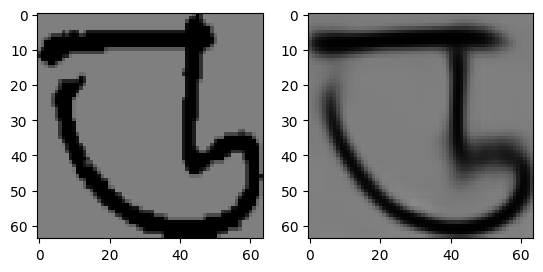

In [ ]:
model.load_state_dict(torch.load('model.pth'))

model.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(DEVICE)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        z, mu, logvar, out = model(imgs)
        print(z.shape, z)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        break

In [ ]:
new_df = df[['Path', 'Label', 'Set']]
new_df

,Path,Label,Set
0,/content/Dataset/Train/200/bcc000183.bmp,200,Train
1,/content/Dataset/Train/200/bcc000108.bmp,200,Train
2,/content/Dataset/Train/200/bcc000145.bmp,200,Train
3,/content/Dataset/Train/200/bcc000171.bmp,200,Train
4,/content/Dataset/Train/200/bcc000082.bmp,200,Train
...,...,...,...
14995,/content/Dataset/Test/181/bcc000020.bmp,181,Test
14996,/content/Dataset/Test/181/bcc000015.bmp,181,Test
14997,/content/Dataset/Test/181/bcc000055.bmp,181,Test
14998,/content/Dataset/Test/181/bcc000016.bmp,181,Test


In [ ]:
def embedding(path):
    img = cv2.imread(path)
    img = transform(img).unsqueeze(0).to(DEVICE)
    z, mu, logvar, out = model(img)
    z = z.squeeze(0).cpu().detach().numpy()
    # mu = mu.squeeze(0).cpu().detach().numpy()
    # return z + mu
    return z

# All Images + All Images (Avg)

In [ ]:
model.load_state_dict(torch.load('model.pth'))

embeddings = []
all_images = new_df['Path'].values

for idx in tqdm(range(len(new_df))):
    img_path = all_images[idx]
    z = embedding(img_path)
    embeddings.append(z)
    # print(z.shape, z)
    # break

100%|██████████| 15000/15000 [01:56<00:00, 128.62it/s]


In [ ]:
embedding_df = pd.DataFrame(embeddings)

merged_df = pd.concat([new_df, embedding_df], axis=1)
merged_df

,Path,Label,Set,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
0,/content/Dataset/Train/200/bcc000183.bmp,200,Train,2.062509,1.133798,0.042949,-0.079372,0.730094,2.150472,-1.016016,...,0.986409,-1.766182,-2.691653,2.968448,0.538975,0.791246,1.769984,0.824242,-0.053847,1.903951
1,/content/Dataset/Train/200/bcc000108.bmp,200,Train,1.854632,0.253912,-1.031696,0.006763,-0.015163,-1.176146,-0.122683,...,-2.616082,0.396043,0.157112,-2.082085,-0.085841,2.109197,-1.264412,2.056727,0.529529,0.337832
2,/content/Dataset/Train/200/bcc000145.bmp,200,Train,-1.007750,0.455130,-1.861171,-0.111327,-2.502349,1.415002,-2.637001,...,-1.048057,-0.428592,2.169366,-3.093138,-1.399534,1.559639,1.449053,-0.304503,-0.404500,-0.324881
3,/content/Dataset/Train/200/bcc000171.bmp,200,Train,1.771030,2.510245,-2.142007,0.749465,0.719571,-1.133419,-1.866267,...,0.403837,0.462390,0.881832,1.703212,0.152147,4.075571,-2.591489,1.968448,-0.168860,3.046009
4,/content/Dataset/Train/200/bcc000082.bmp,200,Train,3.917496,-0.601711,0.208872,-1.211533,0.468214,-0.031765,0.825686,...,-2.447433,-1.056660,-2.583271,0.622253,0.581156,-1.375990,1.550234,-0.844650,-0.260236,-0.587718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,/content/Dataset/Test/181/bcc000020.bmp,181,Test,-2.113739,0.936694,2.005781,-3.607665,0.286260,-2.594781,-0.054727,...,0.173682,-0.355862,3.277199,0.722150,0.096987,-0.975844,-2.826555,3.199562,2.205777,-2.340580
14996,/content/Dataset/Test/181/bcc000015.bmp,181,Test,-0.189497,1.523423,-0.786696,-2.472854,-1.442133,-2.740911,-0.815119,...,-0.910377,0.779537,4.213536,2.862655,-0.897047,-0.558651,-1.493128,4.181517,2.257858,-2.215880
14997,/content/Dataset/Test/181/bcc000055.bmp,181,Test,-1.372682,0.688308,-0.541824,-5.110446,-0.504153,1.043717,-3.141962,...,1.132809,-0.263104,3.921479,-1.998243,0.154074,0.364368,-1.175906,1.384666,0.528045,-0.204393
14998,/content/Dataset/Test/181/bcc000016.bmp,181,Test,-1.277432,-0.955437,0.719208,-0.994023,1.836808,-1.569927,2.523993,...,-0.253800,2.202451,0.904753,2.704782,-1.082796,-3.626932,0.919240,3.345623,4.284416,-2.767201


In [ ]:
merged_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/all_images.csv', index=False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/all_images.csv')

,Path,Label,Set,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
0,/content/Dataset/Train/200/bcc000183.bmp,200,Train,2.062509,1.133798,0.042949,-0.079372,0.730094,2.150472,-1.016016,...,0.986409,-1.766182,-2.691653,2.968448,0.538975,0.791246,1.769985,0.824242,-0.053847,1.903951
1,/content/Dataset/Train/200/bcc000108.bmp,200,Train,1.854632,0.253912,-1.031696,0.006763,-0.015163,-1.176146,-0.122683,...,-2.616082,0.396043,0.157112,-2.082085,-0.085841,2.109197,-1.264412,2.056727,0.529529,0.337832
2,/content/Dataset/Train/200/bcc000145.bmp,200,Train,-1.007750,0.455130,-1.861171,-0.111327,-2.502349,1.415002,-2.637001,...,-1.048057,-0.428592,2.169366,-3.093138,-1.399534,1.559639,1.449053,-0.304503,-0.404500,-0.324881
3,/content/Dataset/Train/200/bcc000171.bmp,200,Train,1.771030,2.510245,-2.142007,0.749465,0.719571,-1.133419,-1.866267,...,0.403837,0.462390,0.881832,1.703212,0.152147,4.075571,-2.591489,1.968448,-0.168860,3.046009
4,/content/Dataset/Train/200/bcc000082.bmp,200,Train,3.917496,-0.601711,0.208872,-1.211533,0.468214,-0.031765,0.825685,...,-2.447433,-1.056660,-2.583271,0.622253,0.581156,-1.375990,1.550234,-0.844650,-0.260236,-0.587719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,/content/Dataset/Test/181/bcc000020.bmp,181,Test,-2.113739,0.936694,2.005781,-3.607665,0.286260,-2.594781,-0.054727,...,0.173682,-0.355862,3.277199,0.722150,0.096987,-0.975844,-2.826555,3.199562,2.205777,-2.340580
14996,/content/Dataset/Test/181/bcc000015.bmp,181,Test,-0.189497,1.523423,-0.786696,-2.472854,-1.442133,-2.740911,-0.815119,...,-0.910377,0.779537,4.213536,2.862655,-0.897047,-0.558651,-1.493128,4.181517,2.257858,-2.215880
14997,/content/Dataset/Test/181/bcc000055.bmp,181,Test,-1.372682,0.688308,-0.541824,-5.110446,-0.504153,1.043717,-3.141962,...,1.132809,-0.263104,3.921479,-1.998243,0.154074,0.364368,-1.175906,1.384666,0.528045,-0.204393
14998,/content/Dataset/Test/181/bcc000016.bmp,181,Test,-1.277432,-0.955437,0.719208,-0.994023,1.836808,-1.569927,2.523993,...,-0.253800,2.202451,0.904753,2.704782,-1.082796,-3.626932,0.919240,3.345623,4.284416,-2.767201


In [ ]:
embd_all_images = {}
embd_all_images_avg = {}

for i in range(172, 172+50):
    temp_df = merged_df.loc[merged_df['Label'] == str(i)]
    values = temp_df.iloc[:, 3:].values
    values = np.sum(values, axis=0)

    embd_all_images[i] = values
    embd_all_images_avg[i] = values/len(temp_df)

embd_all_images_df = pd.DataFrame(embd_all_images)
embd_all_images_avg_df = pd.DataFrame(embd_all_images_avg)

embd_all_images_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_all_images.csv', index=False)
embd_all_images_avg_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_all_images_avg_df.csv', index=False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_all_images_avg_df.csv')

,172,173,174,175,176,177,178,179,180,181,...,212,213,214,215,216,217,218,219,220,221
0,1.164137,-0.206113,1.399231,1.990738,0.758792,0.668722,0.168505,-0.815155,0.220957,-0.922841,...,0.600480,0.611271,2.785310,1.413832,1.659949,0.942627,-0.505532,0.876789,0.445881,0.245082
1,-3.274087,-2.244343,0.408322,0.296199,0.338270,0.218204,-0.458023,0.840246,0.170601,0.659790,...,-0.760669,-1.242803,1.717283,-0.265508,0.213106,-0.223115,-0.793410,-0.100040,1.127559,1.167942
2,0.105030,-0.429174,-0.642804,-1.183635,-0.119931,-0.357670,0.671853,0.037632,-0.011988,-0.241640,...,0.826585,-0.713541,-0.650830,0.397866,-0.040839,0.615141,-1.221043,-0.716221,-0.383330,-0.415697
3,0.441725,0.444389,0.017288,0.142100,-0.354511,-0.280644,-0.676017,-1.625204,-0.324646,-2.732311,...,-0.377796,0.895420,1.434435,-0.744563,1.015727,0.473487,-0.926416,-2.066343,-0.742246,-1.515479
4,1.012508,0.165947,0.857366,0.611404,0.833395,0.746366,0.756452,0.392619,2.239055,0.152622,...,1.226270,-0.347554,-1.098072,-1.901452,-0.605984,-0.970045,-1.128649,-1.433528,0.353298,0.664859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-1.430675,-0.319956,1.347046,1.422404,0.318982,-0.520575,0.002449,-1.678303,-0.282822,0.203422,...,1.052577,-1.023318,1.376999,-0.023995,2.024979,0.117053,0.008781,0.650011,0.034880,-2.848772
60,-0.569486,-0.073969,-0.483062,-0.190283,-1.080554,-0.194929,-1.171435,2.047071,1.000187,-1.216336,...,-0.722908,1.074419,-0.350155,0.076873,-0.392526,0.329645,1.057227,0.006825,-0.214278,-0.662853
61,0.038428,0.902940,1.690543,1.041765,2.574091,2.734606,-0.012245,2.143514,2.538051,2.667095,...,0.011359,0.114064,1.122976,-0.677719,-0.671519,-0.894742,-0.641914,-0.706046,1.620103,1.015788
62,-0.410625,-1.256439,0.520549,-0.253452,2.188725,2.262009,0.251610,1.006658,1.550941,1.657540,...,0.619003,0.360213,-0.437870,0.830481,0.026177,1.057834,0.006831,0.138586,2.725308,1.134259


In [ ]:
embd_random1 = {}

for i in range(172, 172+50):
    temp_df = merged_df.loc[merged_df['Label'] == str(i)]
    temp_df.reset_index(drop=True, inplace=True)

    value = temp_df.iloc[random.randint(0, len(temp_df)), :][3:].values

    embd_random1[i] = value

embd_random1_df = pd.DataFrame(embd_random1)

embd_random1_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random1.csv', index=False)

In [ ]:
pd.read_csv("/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random1.csv")

,172,173,174,175,176,177,178,179,180,181,...,212,213,214,215,216,217,218,219,220,221
0,3.924375,0.344038,2.476470,3.568545,0.261779,1.453854,1.100095,-0.355160,-1.071372,-1.940457,...,-3.081232,1.628540,1.584019,1.502130,2.307916,2.878056,-1.210411,2.676897,1.053884,0.486885
1,-3.876679,-0.966367,-0.529485,1.734805,-1.122830,0.636819,-0.212478,0.184694,0.655915,0.272179,...,-0.031424,-1.069365,-1.160371,0.961883,0.022341,-0.778773,-0.369125,0.915490,1.847652,-0.108720
2,-0.325026,-0.647237,-2.205658,-0.419534,0.476016,-1.097463,-1.682538,1.082682,1.081854,0.560205,...,2.740889,-2.500487,-0.388626,0.838029,-1.112123,0.276046,-1.407412,-2.942692,-1.320803,-0.098315
3,1.980960,2.115265,1.228694,1.198176,-1.109822,-1.139944,-0.600291,-2.324336,-1.416459,-4.595863,...,0.457906,1.181002,-0.040469,0.066815,2.272717,1.929200,-2.302116,-2.111198,0.236974,-3.044611
4,2.531471,2.888775,8.219403,2.295432,0.680743,0.014793,2.106422,0.931263,0.508306,-0.938416,...,2.096330,-2.028709,-2.074423,-0.366432,-0.691192,-2.058606,-3.952889,-1.671660,0.054571,-0.343970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-0.435364,-3.531534,6.910500,3.198704,1.148277,2.804846,-1.903344,0.125619,-1.014720,-1.455359,...,1.076102,-3.830169,2.599503,-0.086890,-0.481339,0.227902,1.519692,1.592525,-1.417864,-2.725890
60,-2.091781,1.428083,-0.550462,-0.977479,-1.584873,-0.258770,0.007842,1.905312,1.266674,-1.087568,...,-3.110436,1.481197,2.111945,-0.062385,0.775777,-0.077230,1.712225,0.261782,-0.938569,-2.104914
61,-1.054816,6.829783,2.356432,1.335613,2.573347,1.081221,0.800665,1.048063,1.722578,2.199487,...,0.712160,5.009409,-1.297036,0.824900,-0.580287,-2.395399,-4.177290,-0.904171,2.764661,-2.033062
62,-1.105398,0.343625,-1.872889,-0.346186,3.303620,0.472978,-0.239561,1.582175,1.072094,1.332682,...,2.124832,-0.220792,-0.711043,1.448845,0.226739,-0.397100,-1.862198,-1.314393,3.440343,0.999768


In [ ]:
embd_all_images = {}
embd_all_images_avg = {}

for i in range(172, 172+50):
    temp_df = merged_df.loc[merged_df['Label'] == str(i)]
    values = temp_df.iloc[:, 3:].values
    values = np.sum(values, axis=0)

    embd_all_images[i] = values
    embd_all_images_avg[i] = values/len(temp_df)

embd_all_images_df = pd.DataFrame(embd_all_images)
embd_all_images_avg_df = pd.DataFrame(embd_all_images_avg)

embd_all_images_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_all_images.csv', index=False)
embd_all_images_avg_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_all_images_avg_df.csv', index=False)

In [ ]:
N = 10
embd_random10 = {}
embd_random10_avg = {}

for i in range(172, 172+50):
    temp_df = merged_df.loc[merged_df['Label'] == str(i)]
    temp_df.reset_index(drop=True, inplace=True)

    idxs = [random.randint(0, len(temp_df)-1) for _ in range(N)]

    temp_df = temp_df.loc[idxs, :]

    values = temp_df.iloc[:, 3:].values
    values = np.sum(values, axis=0)

    embd_random10[i] = values
    embd_random10_avg[i] = values/len(temp_df)

embd_random10_df = pd.DataFrame(embd_random10)
embd_random10_avg_df = pd.DataFrame(embd_random10_avg)

embd_random10_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random10.csv', index=False)
embd_random10_avg_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random10_avg.csv', index=False)

In [ ]:
pd.read_csv("/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random10_avg.csv")

,172,173,174,175,176,177,178,179,180,181,...,212,213,214,215,216,217,218,219,220,221
0,1.382376,0.604467,1.254608,1.422294,0.948141,0.367660,1.286299,-0.829078,-0.196125,-1.083982,...,1.284966,1.321745,2.730770,1.947900,1.313676,1.270781,-0.061816,1.300597,0.190074,0.719115
1,-2.713742,-2.003876,0.347637,0.233464,0.683981,0.174282,-0.692271,1.439211,0.131789,-0.384731,...,0.683609,-0.803425,1.733519,0.009761,0.405231,0.333759,0.156248,-0.303831,1.317558,0.639744
2,-0.816983,-1.032411,-0.990146,-1.122435,-0.452800,-0.043563,0.925450,0.563630,0.100731,-0.804492,...,0.921550,-1.476422,-0.869293,0.006762,0.147724,0.875212,-1.183025,-1.065315,-0.336713,-0.334108
3,0.279494,1.317816,0.146852,-0.640753,-0.539152,-0.595102,-0.306541,-2.185742,-0.858852,-3.235400,...,0.348334,0.676500,0.903908,-0.401359,1.008860,1.068606,-1.012440,-2.839626,-0.735031,-0.789449
4,0.783575,0.431240,0.900631,0.751424,1.087136,0.384869,1.626794,0.446211,1.604274,-0.679237,...,0.207620,-0.168603,-0.675878,-1.158033,-0.478015,-1.376666,-1.634384,-1.916127,-0.028018,0.421203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-2.564034,-1.113613,1.570252,1.214689,0.548723,-0.313875,0.421647,-1.485429,-0.932491,0.966720,...,1.240510,-1.491133,2.349118,0.095765,2.902573,0.182157,-0.813895,0.400699,-0.014409,-4.045614
60,-0.270405,-0.034575,-0.758238,-0.175333,-0.855886,-0.263095,-1.203571,1.832310,1.129442,-1.102544,...,-1.665654,1.029358,-0.351138,-0.527106,-0.165193,-0.006886,-0.230279,-0.070217,-0.361744,0.019008
61,1.308316,2.288856,2.534328,1.070131,3.082278,2.489928,-1.028208,2.073243,1.998207,2.286982,...,1.183695,1.079344,0.986075,-0.556996,-1.047732,-0.307950,-0.004789,-0.947148,1.385925,0.910106
62,-1.138623,-0.918761,1.043317,-0.295764,2.049467,2.321700,0.833484,0.767877,1.359202,0.993345,...,0.506591,0.223678,-0.714203,0.586252,-0.489918,0.788170,0.466750,-0.178866,2.400853,1.677973


In [ ]:
N = 50
embd_random50 = {}
embd_random50_avg = {}

for i in range(172, 172+50):
    temp_df = merged_df.loc[merged_df['Label'] == str(i)]
    temp_df.reset_index(drop=True, inplace=True)

    idxs = [random.randint(0, len(temp_df)-1) for _ in range(N)]

    temp_df = temp_df.loc[idxs, :]

    values = temp_df.iloc[:, 3:].values
    values = np.sum(values, axis=0)

    embd_random50[i] = values
    embd_random50_avg[i] = values/len(temp_df)

embd_random50_df = pd.DataFrame(embd_random50)
embd_random50_avg_df = pd.DataFrame(embd_random50_avg)

embd_random50_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random50_df.csv', index=False)
embd_random50_avg_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random50_avg_df.csv', index=False)

In [ ]:
N = 100
embd_random100 = {}
embd_random100_avg = {}

for i in range(172, 172+50):
    temp_df = merged_df.loc[merged_df['Label'] == str(i)]
    temp_df.reset_index(drop=True, inplace=True)

    idxs = [random.randint(0, len(temp_df)-1) for _ in range(N)]

    temp_df = temp_df.loc[idxs, :]

    values = temp_df.iloc[:, 3:].values
    values = np.sum(values, axis=0)

    embd_random100[i] = values
    embd_random100_avg[i] = values/len(temp_df)

embd_random100_df = pd.DataFrame(embd_random100)
embd_random100_avg_df = pd.DataFrame(embd_random100_avg)

embd_random100_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random100_df.csv', index=False)
embd_random100_avg_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random100_avg_df.csv', index=False)

In [ ]:
import pandas as pd
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [ ]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.5), (0.5)),
])

embeddings = []
classes = []

for idx in range(172, 172+50):
    img_path = f'/content/Dataset/Test/{idx}/bcc000020.bmp'
    img = test_transform(cv2.imread(img_path))
    # print(img.shape)

    z, mu, logvar, out = model(img.unsqueeze(0).to(DEVICE))
    embd = z
    embd = embd.view(-1, embd.shape[1])
    # print(embd.shape, recon.shape)
    embeddings.append(list(embd[0].cpu().detach().numpy()))
    classes.append(idx)

np.array(embeddings).shape

(50, 32)

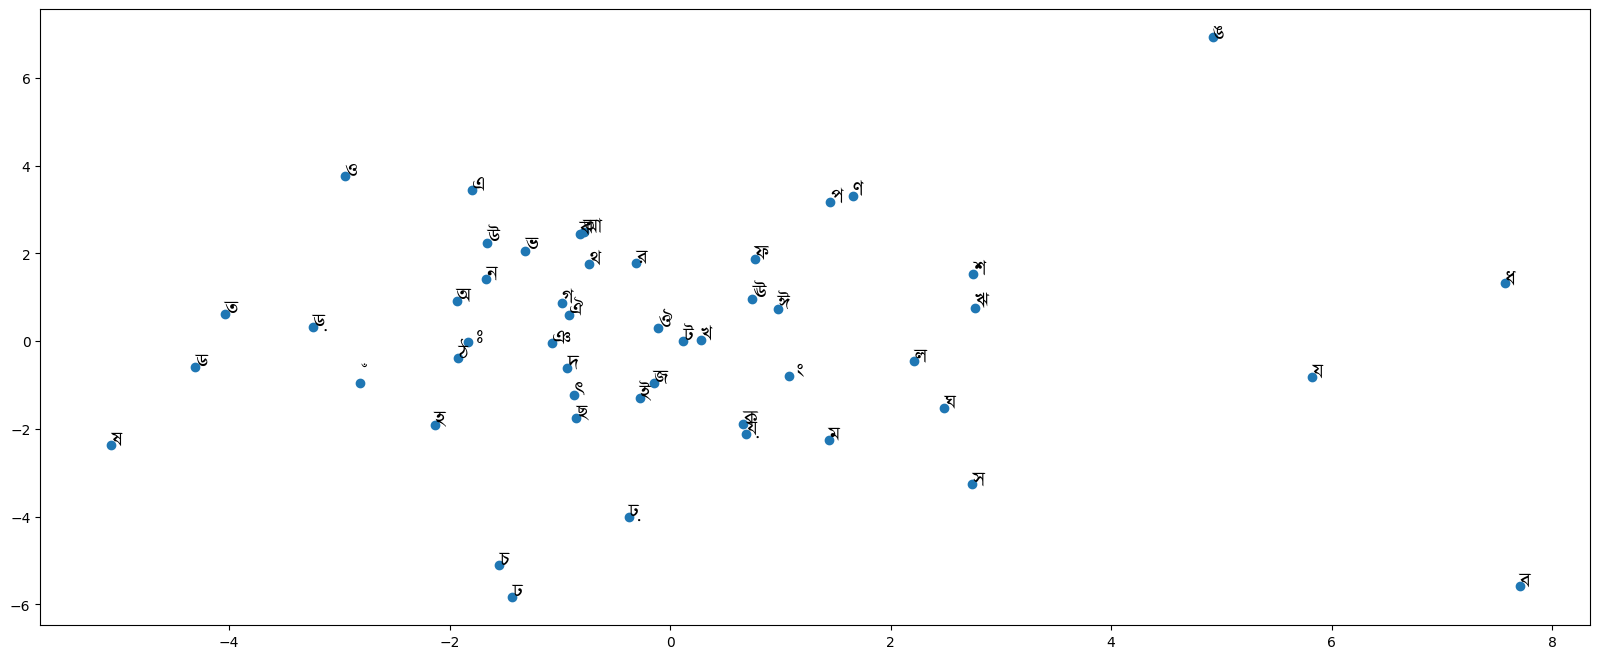

In [ ]:
prop = fm.FontProperties(fname='/content/drive/MyDrive/ZSClassification/VAEViT/Bangla/kalpurush.ttf')

X = embeddings
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.figure(figsize=(20, 8))
plt.scatter(result[:, 0], result[:, 1])

chars = [
    'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড',
    'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ',' ং',' ঃ', ' ঁ',
    # 'অনুস্বার','বিসর্গ', 'চন্দ্রবিন্দু'
]

for i, char in enumerate(chars):
    plt.annotate(
        char,
        xy = (result[i, 0], result[i, 1]),
        fontproperties=prop,
        fontsize=15
    )

plt.show()

In [ ]:
df = pd.DataFrame(embeddings)
df['Class'] = classes
df.to_csv('/content/drive/MyDrive/ZSClassification/VAEViT/Bangla/BanglaVAESingle.csv', index=False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/ZSClassification/VAEViT/Bangla/BanglaVAESingle.csv')

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,Class
0,0.826601,-0.643228,0.644723,-2.108765,1.959371,0.060883,2.652870,-0.332207,2.230372,0.595964,...,0.678269,-0.331549,-3.858577,0.793181,-0.699412,1.374440,-0.965482,-0.873526,-0.791988,172
1,3.736749,1.637350,-2.625059,-1.460237,-0.556708,1.272279,0.482792,0.731435,2.214306,-0.328877,...,1.891903,2.809788,-0.506467,0.697121,-1.162924,-0.857342,-2.239981,0.796172,1.427653,173
2,-0.040944,0.796215,0.918663,-0.261428,0.678231,-0.200453,0.895466,-0.349800,-0.066551,-1.098631,...,-2.083966,1.135637,0.726843,0.696616,2.022157,1.513507,0.426078,0.129852,-0.354947,174
3,-1.889292,1.616049,1.379666,1.982368,2.118025,0.742107,-0.686495,1.198862,1.176368,2.170379,...,1.820336,0.830886,0.160675,1.117020,-0.658923,-1.391240,0.012814,-0.296098,2.750925,175
4,-1.389715,-0.624717,-1.685383,-0.746781,1.716130,0.805919,-0.846912,0.090554,-1.605566,0.257108,...,-0.078675,-0.351137,-1.091793,0.643995,1.096201,-0.487024,0.851399,-0.185929,0.432738,176
5,-0.604401,0.387451,-0.306259,-0.174870,-0.237058,1.625639,0.232531,0.435224,-1.438434,0.415707,...,-0.463129,-0.682788,0.476823,-0.411264,0.324976,-1.039316,-1.568914,-1.047128,-0.397039,177
6,-1.582053,-0.311623,0.606029,-0.197412,1.166133,0.541006,0.046544,-0.987694,1.261434,0.724388,...,-0.085431,-0.044068,0.206734,0.597506,-1.035706,-0.928640,-0.817498,-2.015711,-1.547561,178
7,0.386484,0.384573,-4.706202,1.528435,-0.300475,-1.518041,3.728112,-3.094047,-3.644237,0.084399,...,-0.405868,-0.850751,0.837200,0.029461,-0.964801,-1.131918,0.419230,-2.800137,0.530804,179
8,0.652930,0.192295,1.979060,1.379208,1.075105,0.024458,-1.042839,1.797479,0.519989,1.568434,...,1.264799,-0.415301,-1.570739,1.234959,1.005117,-1.096753,1.677053,-1.508980,-0.895949,180
9,1.973098,-0.533741,-1.265935,1.977097,1.654122,-2.480383,1.498891,-1.393463,-1.719841,1.066480,...,1.301729,-0.413112,1.813884,-0.001200,-0.244871,-0.113902,0.712959,1.668344,-0.885490,181


In [ ]:
embeddings = []
for idx in range(172, 172+50):
    # img_path = f'/content/DatasetBangla/Train/{idx}/'
    # imgs_paths = glob.glob(os.path.join(img_path, '*.*'))

    train_path = f'/content/Dataset/Train/{idx}/'
    train_imgs = glob.glob(os.path.join(train_path, '*.bmp'))

    test_path = f'/content/Dataset/Test/{idx}/'
    test_imgs = glob.glob(os.path.join(test_path, '*.bmp'))

    imgs_paths = train_imgs + test_imgs

    embeds = 0
    for img_path in imgs_paths:
        img = test_transform(cv2.imread(img_path))
        z, mu, logvar, out = model(img.unsqueeze(0).to(DEVICE))
        embd = z.cpu().detach().numpy().squeeze()
        embeds += embd

    embeds = embeds / len(imgs_paths)
    # print(embeds.shape, embeds)
    embeddings.append(embeds)

np.array(embeddings).shape

(50, 32)

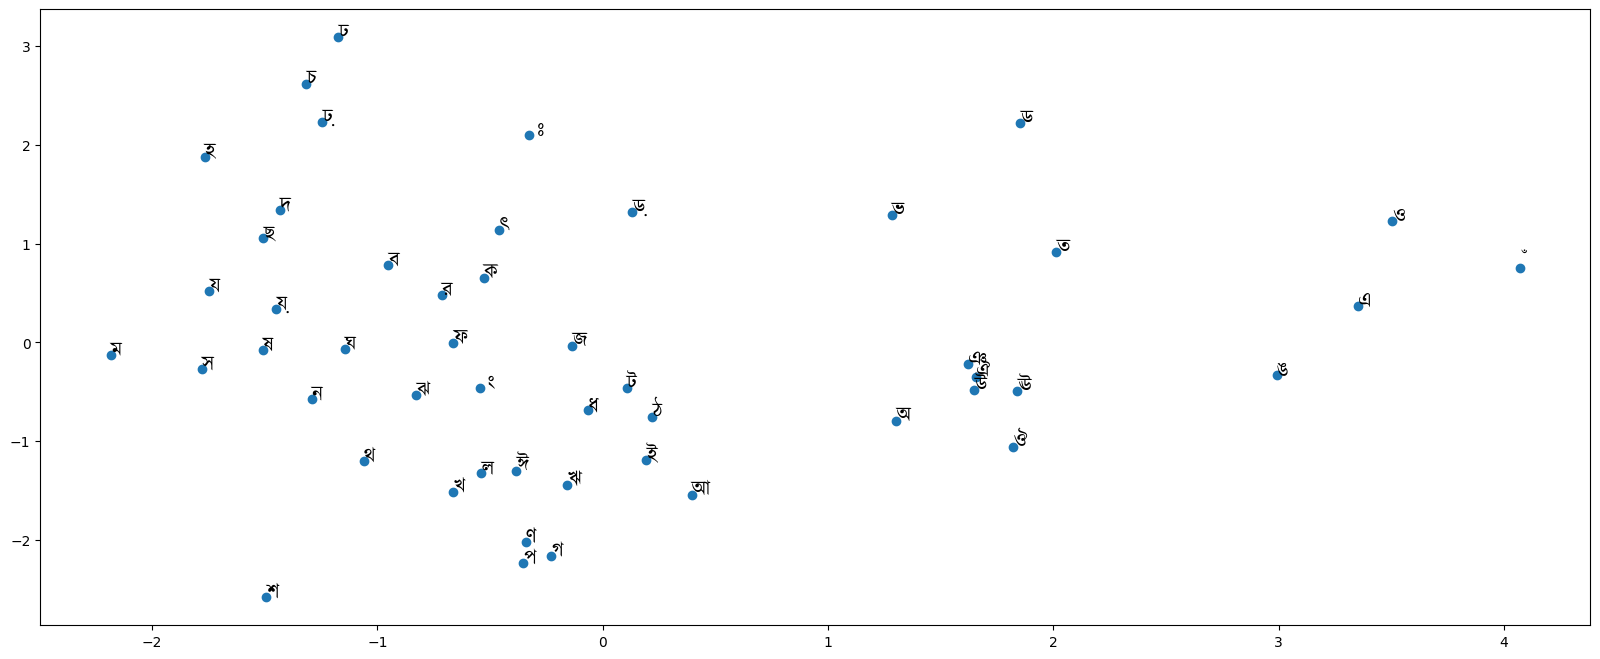

In [ ]:
prop = fm.FontProperties(fname='/content/drive/MyDrive/ZSClassification/VAEViT/Bangla/kalpurush.ttf')

X = embeddings
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.figure(figsize=(20, 8))
plt.scatter(result[:, 0], result[:, 1])

chars = [
    'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড',
    'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ',' ং',' ঃ', ' ঁ',
    # 'অনুস্বার','বিসর্গ', 'চন্দ্রবিন্দু'
]

for i, char in enumerate(chars):
    plt.annotate(
        char,
        xy = (result[i, 0], result[i, 1]),
        fontproperties=prop,
        fontsize=15
    )

plt.show()

In [ ]:
df = pd.DataFrame(embeddings)
df['Class'] = [_ for _ in range(172, 172+50)]
df.to_csv('/content/drive/MyDrive/ZSClassification/VAEViT/Bangla/BanglaVAEMean.csv', index=False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/ZSClassification/VAEViT/Bangla/BanglaVAEMean.csv')

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,Class
0,0.224432,-0.853822,-0.969172,-0.163280,-0.206675,-0.156833,1.127503,-0.992066,1.059984,0.362823,...,0.858383,-0.820510,-0.809624,0.091335,-0.346087,0.275003,-0.819448,0.625088,-0.273669,172
1,0.851991,-0.043545,-0.915231,-0.164573,0.034638,-0.207057,0.316868,-1.788211,0.734384,0.606281,...,-0.392102,-0.297499,-1.146431,0.909493,-0.451957,0.046817,-0.836126,0.320403,0.647409,173
2,-0.529589,0.388332,0.377333,-0.062079,0.622375,1.430314,-0.766472,0.867949,-0.074874,-0.578985,...,0.178268,-0.313943,-0.387799,-0.116724,0.270182,-0.650512,0.535186,-0.320670,0.654528,174
3,-0.999995,0.345786,0.769604,0.347072,0.079885,0.948441,-0.710789,0.894269,-0.102432,-0.215492,...,-0.160599,0.114267,-0.255144,0.307728,0.084192,-0.334329,-0.397276,-0.457926,0.979654,175
4,0.426521,-0.195800,0.363893,-0.011155,0.465291,0.413461,-0.568482,0.281516,-0.862868,-0.368040,...,0.399159,0.428860,-0.403621,0.033043,0.721691,-0.810929,0.177303,-0.212001,-0.330528,176
5,0.045387,0.150965,-0.344388,0.324279,0.408732,0.409082,0.151386,0.823832,-1.164977,-0.678006,...,-0.138858,0.014453,-0.484614,0.037975,1.018518,-0.721365,0.048352,-0.296173,-0.012248,177
6,-1.698954,-0.851240,0.059178,0.569577,0.498584,0.194991,-0.793716,-0.369191,0.353798,0.190228,...,0.013940,0.103272,0.057208,-0.082290,-0.860837,-0.719525,-0.750888,-0.502629,-0.121507,178
7,-0.618184,-0.656365,-1.012339,0.255168,-0.184739,-1.596663,2.296070,-0.975852,-2.132984,-0.294270,...,-0.310713,-0.134044,-0.913060,-1.076355,0.906515,-0.538593,0.337439,-0.340129,-0.620530,179
8,-0.318522,-0.141155,-0.440288,0.149471,0.760625,0.106088,0.564407,0.540157,-0.899747,0.039148,...,0.107159,-0.826902,-1.050706,-0.189299,0.682585,-0.432513,1.022537,-1.373820,0.515652,180
9,0.989945,-0.412908,0.511537,0.701074,-0.265188,-0.882063,2.039047,-0.024316,-2.095788,0.437936,...,-0.164901,0.411150,0.705925,-0.287891,-0.672088,-0.394884,0.503995,1.188120,-0.891649,181
